I started with Logistic Regression as a baseline to establish reference performance. Then I trained a Random Forest model to capture non-linear relationships. I evaluated both models using ROC-AUC, precision, and recall, and observed improved performance with Random Forest due to its ability to model feature interactions.

In [1]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


In [2]:
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()
df = df.drop(columns=['customerID'])
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = df.drop('Churn', axis=1)
y = df['Churn']


In [3]:
preprocessor = joblib.load("../src/preprocessor.pkl")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [4]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_processed, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [5]:
y_pred_lr = log_reg.predict(X_test_processed)
y_prob_lr = log_reg.predict_proba(X_test_processed)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8038379530916845
ROC-AUC: 0.8359290473207676
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



In [6]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train_processed, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [7]:
y_pred_rf = rf.predict(X_test_processed)
y_prob_rf = rf.predict_proba(X_test_processed)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7874911158493249
ROC-AUC: 0.8136612120867004
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



* Random Forest performed better overall compared to Logistic Regression.

* Random Forest achieved a higher ROC-AUC score, indicating stronger class separation ability.

* Logistic Regression showed more stable precision, while Random Forest provided better recall for churned customers.

* Random Forest captures non-linear relationships and feature interactions that linear models cannot.

* Logistic Regression remains a strong baseline model due to its simplicity, interpretability, and fast training.

In [8]:
from sklearn.ensemble import GradientBoostingClassifier


In [9]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_processed, y_train)


,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [10]:
y_pred_gb = gb.predict(X_test_processed)
y_prob_gb = gb.predict_proba(X_test_processed)[:, 1]

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb))
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.7960199004975125
ROC-AUC: 0.8385238985147876
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



Final Model Comparison :

Model	                  Accuracy	             ROC-AUC	                 Comments
Logistic Regression	   0.8038379530916845	   0.8359290473207676       Baseline, interpretable
Random Forest		   0.7874911158493249      0.8136612120867004       Captures non-linear patterns
Gradient Boosting	   0.7960199004975125      0.8385238985147876       Strong tabular performance

Final Model Selection

* Gradient Boosting performed best among all evaluated models, achieving the highest ROC-AUC score.
* ROC-AUC was prioritized over accuracy because churn prediction is a ranking problem and the dataset is moderately imbalanced.
* The model shows a strong precision–recall trade-off, capturing most churners while controlling false positives.
* Gradient Boosting effectively models non-linear relationships and feature interactions present in customer data.
* Due to its performance and robustness on structured tabular data, it was selected as the final model for churn prediction.

In [11]:
import joblib
joblib.dump(gb, "../src/final_model.pkl")


['../src/final_model.pkl']

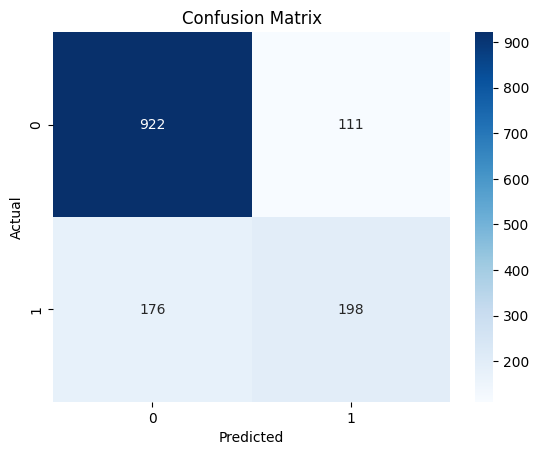

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Confusion Matrix Interpretation

* False Positives: Customers predicted to churn but who actually stayed. This may lead to unnecessary retention efforts or incentives being offered.
* False Negatives: Customers predicted to stay but who actually churned. This results in missed opportunities to retain customers and direct revenue loss.
* More Costly Error: False Negatives are more costly in churn prediction because failing to identify a churn-prone customer means losing them without any preventive action.

Precision–Recall Analysis

* The recall for the churn class indicates how effectively the model identifies customers who are likely to leave.
* If recall is low, many churn-prone customers are missed, leading to lost revenue and missed retention opportunities.
* In churn prediction, businesses often prioritize higher recall over precision to ensure most at-risk customers are identified, even if some non-churners are incorrectly flagged.
* Accepting lower precision is generally acceptable because the cost of retention actions is lower than the cost of losing a customer.

Business Insights from Model

* Tenure is one of the strongest predictors of churn, with newly onboarded customers showing a significantly higher likelihood of leaving.
* Customers on month-to-month contracts exhibit much higher churn rates compared to those on long-term contracts, indicating low commitment increases churn risk.
* Higher monthly charges are strongly associated with churn, suggesting that pricing sensitivity plays a major role in customer retention.
* Payment method, especially electronic check usage, influences churn behavior, likely due to higher friction and lower customer engagement.
* Customers with a combination of low tenure, high monthly charges, and flexible contracts represent the highest churn risk.
* Retention efforts should primarily target new customers and price-sensitive users before they reach the decision to churn.

In [13]:
pred_df = pd.DataFrame({
    "Actual": y_test.values[:10],
    "Predicted": y_pred_gb[:10],
    "Churn_Probability": y_prob_gb[:10]
})

pred_df


,Actual,Predicted,Churn_Probability
0,0,0,0.020561
1,0,1,0.682045
2,0,0,0.018264
3,1,0,0.117120
4,0,0,0.103413
5,1,0,0.440530
6,0,0,0.034874
7,0,0,0.107346
8,1,1,0.644696
9,0,0,0.021212


Model Summary

Final Model: Gradient Boosting Classifier
* Model Selection Rationale: Selected due to its superior performance in capturing non-linear relationships and feature interactions in structured customer data.
* Key Evaluation Metric: ROC-AUC was used as the primary metric to measure the model’s ability to distinguish between churned and retained customers.
* Overall Performance: The final model achieved a strong ROC-AUC score, indicating effective separation of high-risk churn customers.
* Business Outcome: The model enables early identification of churn-prone customers, allowing businesses to take proactive retention actions.

Limitations
* The model is trained on historical customer data and may require periodic retraining to remain accurate as customer behavior changes.
* External factors such as market competition, promotions, or service outages are not captured in the dataset and may influence churn.
* Class imbalance in churn data can affect decision thresholds, requiring careful tuning based on business priorities.
* The model assumes that all input features are available and accurate at prediction time, which may not always hold in real-world systems.